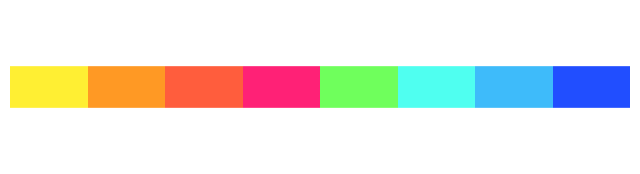

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from copy import deepcopy

def draw_colors(colors):
    # Plot the colors as swatches
    plt.figure(figsize=(8, 2))
    for i, color in enumerate(colors):
        plt.plot([i, i+1], [0, 0], color=color, linewidth=30, solid_capstyle='butt')

    # Remove axes and set display limits
    plt.gca().axis('off')
    plt.xlim(0, len(colors))

    # Show the plot
    plt.show()

new_map = {'1, 1000': "#ffef33",
         '1, 10000': "#ff9924",
         '1, 50000': "#ff5d3d",
         '1, 100000': "#ff2176",
         '2, 1000': "#6fff5c",
         '2, 10000': "#4ffff0",
         '2, 50000': "#3ebbfa",
         '2, 100000': "#214eff",
          }

draw_colors(new_map.values())

files = ['../../../data/out_metrics/results_20250121_174325_paramsize_0_24.pkl',
         '../../../data/out_metrics/results_20250122_043534_paramsize_24_32.pkl',
        ]

In [2]:
# !ls ../../../data/out_metrics/losses_2025*lay_act*0_4*

In [3]:
all_results = dict()
for file_name in files:
    with open(file_name.replace('results', 'losses'), "rb") as file:
        results = dict(pickle.load(file))
    all_results = {**all_results, **results}
    
print(f"Amount of sets: {len(all_results)}")

# Flatten the data while preserving the structure from the tuple keys
flattened_data = {
    "activation_function": [],
    "num_layers": [],
    "n_rows": [],
    "d_model": [],
    "iteration": [],
    "epochs": [],
    "loss": []
}

# Iterate over each dataset size, activation function, and number of layers
for (n_rows, act_fn, n_layers, d_model), list_of_iterations in all_results.items():
    # For each iteration in the dataset size
    for i, iteration_list in enumerate(list_of_iterations):
        # Flatten the iteration list with epochs multiplied by 2 (0, 2, 4, ..., 18)
        for epoch, value in enumerate(iteration_list):
            cur_act_fn = act_fn
            if act_fn == 'default':
                cur_act_fn = "default"
            flattened_data["activation_function"].append(cur_act_fn)
            flattened_data["num_layers"].append(n_layers)
            flattened_data["n_rows"].append(n_rows)
            flattened_data["d_model"].append(d_model)
            flattened_data["iteration"].append(i)
            flattened_data["epochs"].append((epoch+1))
            flattened_data["loss"].append(value)

# Convert to DataFrame for plotting
results_melted = pd.DataFrame(flattened_data)
results_melted.activation_function = results_melted.activation_function.apply(lambda x: {'default': "ReLU", 'GELU':'GELU', 'RAF':"RReLU", 'softmax':'softmax'}[x])
results_melted
# pd.DataFrame(all_results).T

Amount of sets: 32


,activation_function,num_layers,n_rows,d_model,iteration,epochs,loss
0,softmax,1,1000,16,0,1,12.314646
1,softmax,1,1000,16,0,2,12.231563
2,softmax,1,1000,16,0,3,12.149299
3,softmax,1,1000,16,0,4,12.058609
4,softmax,1,1000,16,0,5,11.947066
...,...,...,...,...,...,...,...
47995,softmax,2,100000,128,2,496,0.213337
47996,softmax,2,100000,128,2,497,0.213200
47997,softmax,2,100000,128,2,498,0.212954
47998,softmax,2,100000,128,2,499,0.212854


In [4]:
def draw_acc_epochs(
    results_melted,
    cur_cutoff,
    layer_color_map,
    yticks=None,
    y_lines=None,  # Specific y level for horizontal line
    x="epochs",
    y="accuracy",
    xlabel="Epochs",
    ylabel="Accuracy, %",
    title="Mean accuracy with standard deviation per epoch of training\nfor different data sizes, model size, and layers amount",
):
    cur_results_melted = results_melted[results_melted.epochs <= cur_cutoff].rename(
        columns={
            "n_rows": "data size",
            "n_rows, num_layers": "data size, layers amount",
            "d_model": "model size",
        }
    )

    # Plot with Seaborn
    sns.set_style("white", rc={
    'xtick.bottom': True,
    'ytick.left': True,
    })

    plt.figure(figsize=(9, 5))
    
    
    if y_lines is not None:
        for y_line in y_lines:
            plt.axhline(
                y=y_line,
                color="black",
                alpha=0.7,
                linestyle="--",
                linewidth=0.5,   
            )

    sns.lineplot(
        data=cur_results_melted,
        x=x,
        y=y,
        hue="data size, layers amount",  # Combined hue for Num_Layers and N_rows
        style="model size",
        size="model size",
        palette=layer_color_map,  # Ensure this supports the combined categories
        linewidth=1,
    )

    plt.xlim(0, cur_cutoff)

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    sns.despine(offset=2)
    # Optionally add yticks
    if yticks is not None:
        plt.yticks(yticks)  # Custom y-ticks
        
    # Show the plot
    plt.tight_layout()
    plt.show()

In [5]:
# Generate unique colors for each Num_Layers value
unique_layers = results_melted['num_layers'].unique()
layer_palette = sns.color_palette("Set2", len(unique_layers))
layer_color_map = {layer: color for layer, color in zip(unique_layers, layer_palette)}

results_melted['n_rows, num_layers'] = results_melted['num_layers'].astype(str) + ", " + results_melted['n_rows'].astype(str)  
unique_hues = sorted(results_melted['n_rows, num_layers'].unique())
layer_color_map = {hue: sns.color_palette("Paired")[i % 10] for i, hue in enumerate(unique_hues)}


In [6]:
results_melted.loss.max()

12.392966151237488

30


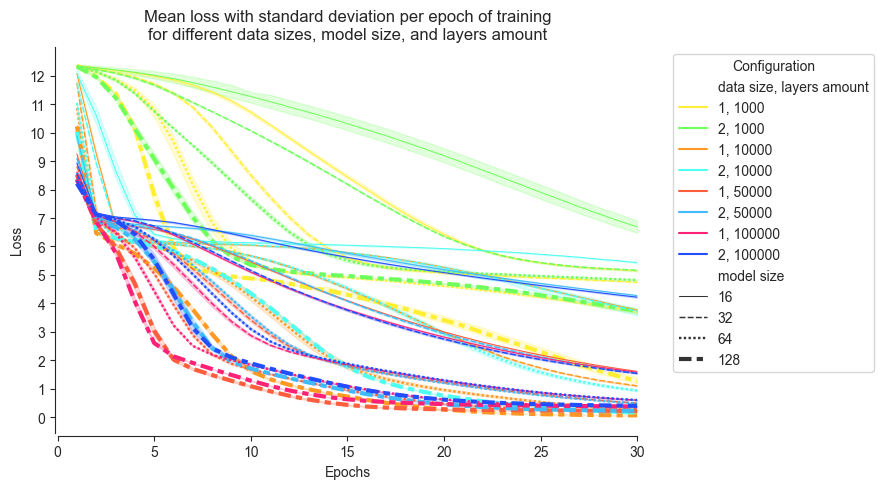

100


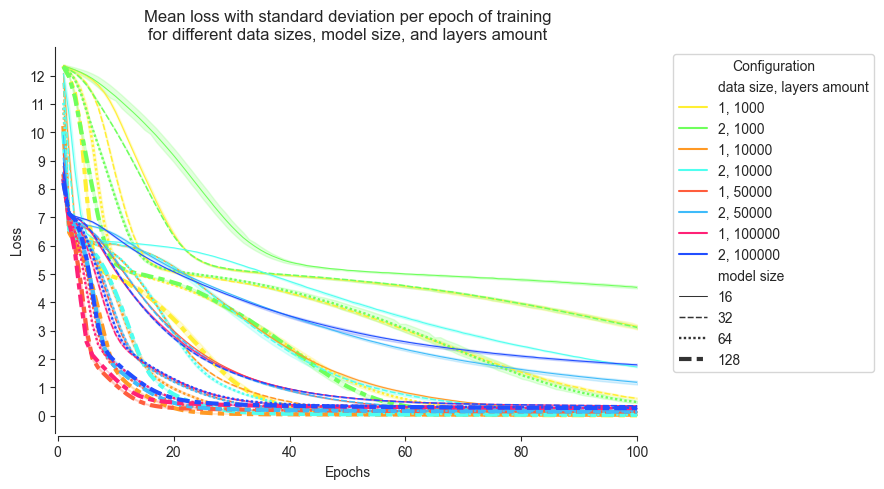

500


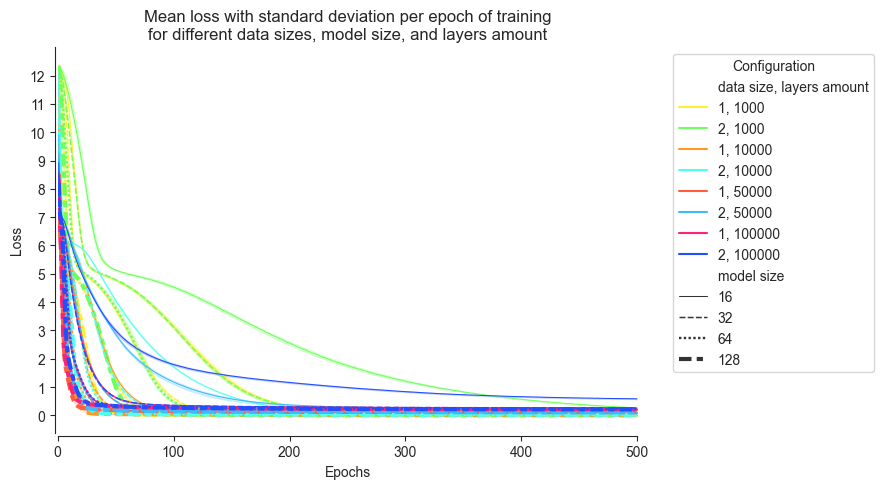

In [7]:
for epochs in [30, 100, results_melted.epochs.max()]:
    print(epochs)
    draw_acc_epochs(
        results_melted,
        epochs,
        new_map,
        yticks=np.arange(0, 13, 1),
        x="epochs",
        y="loss",
        xlabel="Epochs",
        ylabel="Loss",
        title="Mean loss with standard deviation per epoch of training\nfor different data sizes, model size, and layers amount",
    )

## Violins

In [8]:
data_viol = results_melted[results_melted.epochs == max(results_melted.epochs)]
data_viol.head()

,activation_function,num_layers,n_rows,d_model,iteration,epochs,loss,"n_rows, num_layers"
499,softmax,1,1000,16,0,500,0.015085,"1, 1000"
999,softmax,1,1000,16,1,500,0.011703,"1, 1000"
1499,softmax,1,1000,16,2,500,0.013854,"1, 1000"
1999,softmax,1,1000,32,0,500,0.004310,"1, 1000"
2499,softmax,1,1000,32,1,500,0.002456,"1, 1000"


In [9]:
temp = deepcopy(data_viol)
temp.d_model = 'all'

df = pd.concat([data_viol, temp]).set_index(['d_model','num_layers'])[['n_rows', 'loss']]
grouped = (
    df.groupby(['d_model', 'num_layers', 'n_rows'])
    .agg(loss_mean=('loss', 'mean'),
         loss_std=('loss', 'std'),)
)

# Unstack to pivot `n_rows` into columns
final = grouped.unstack(level='n_rows')

# Create a MultiIndex for columns with the correct order
final.columns = pd.MultiIndex.from_tuples(
    [(n_rows, metric) for metric, n_rows in final.columns],
    names=["n_rows", "metric"]
)
# ORDER cols
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]

# ORDER rows
# Define the desired order for 'activation_function'
activation_order = [16, 32, 64, 128]

# Reorder rows based on the activation function order
final = final.loc[activation_order]

# Rearrange columns: first all related to 50000, then 70000
reordered_columns = sorted(final.columns, key=lambda x: x[0])  # Sort by the first level (n_rows)
final = final[reordered_columns]


final.round(2)

n_rows                1000               10000              50000            \
metric             loss_mean loss_std loss_mean loss_std loss_mean loss_std   
d_model num_layers                                                            
16      1               0.01     0.00      0.02      0.0      0.12      0.0   
        2               0.27     0.01      0.03      0.0      0.22      0.0   
32      1               0.00     0.00      0.02      0.0      0.11      0.0   
        2               0.01     0.00      0.02      0.0      0.12      0.0   
64      1               0.00     0.00      0.02      0.0      0.11      0.0   
        2               0.00     0.00      0.02      0.0      0.11      0.0   
128     1               0.00     0.00      0.03      0.0      0.11      0.0   
        2               0.00     0.00      0.02      0.0      0.11      0.0   

n_rows                100000           
metric             loss_mean loss_std  
d_model num_layers                     
16      1               0.26     0.00  
        2               0.59     0.01  
32      1               0.22     0.00  
        2               0.26     0.00  
64      1               0.21     0.00  
        2               0.22     0.00  
128     1               0.22     0.00  
        2               0.21     0.00

In [13]:
def draw_violins(
    data_viol, 
    x, 
    y, 
    xlabel, 
    ylabel, 
    title, 
    yticks=None, 
    hue=None, 
    return_ax=False, 
    ax=None
):
    PALETTE_PARAMS = "Accent"
    PALETTE = "Set2"
    data_dict = {
        "x": x,
        "y": y,
        "palette": list(new_map.values())[3::4],
        "linewidth": 0.5,
    }
    if hue:
        data_dict["hue"] = hue
        data_dict["dodge"] = True
    if ax:
        data_dict["ax"] = axs[col]
        
        
    sns.set_style("white", rc={
        'xtick.bottom': True,
        'ytick.left': True,
    })
    ax = sns.violinplot(
        data_viol,
        **data_dict,
        cut=0,
        legend=False,
        scale="count", 
        alpha=0.3
    )
    plt.setp(ax.collections, alpha=0.6)
    ax = sns.stripplot(data_viol, **data_dict, legend=True, alpha=0.9)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    sns.despine(offset=2)
    # Optionally add yticks
    if yticks is not None:
        ax.set_yticks(yticks)  # Custom y-ticks
    if return_ax:
        return ax

In [14]:
data_viol.loss.max()

0.59104360592411

All together


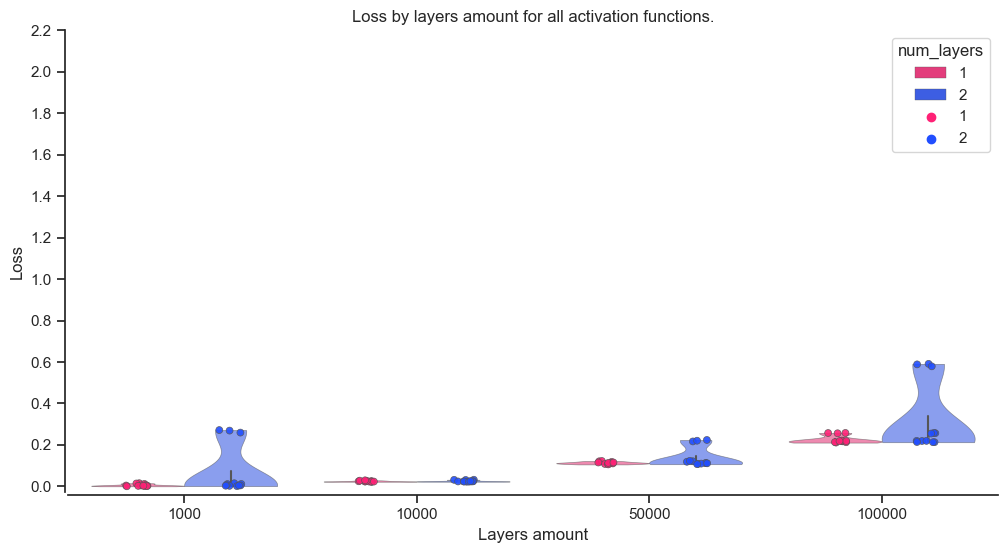

Separated


<Figure size 1400x400 with 0 Axes>

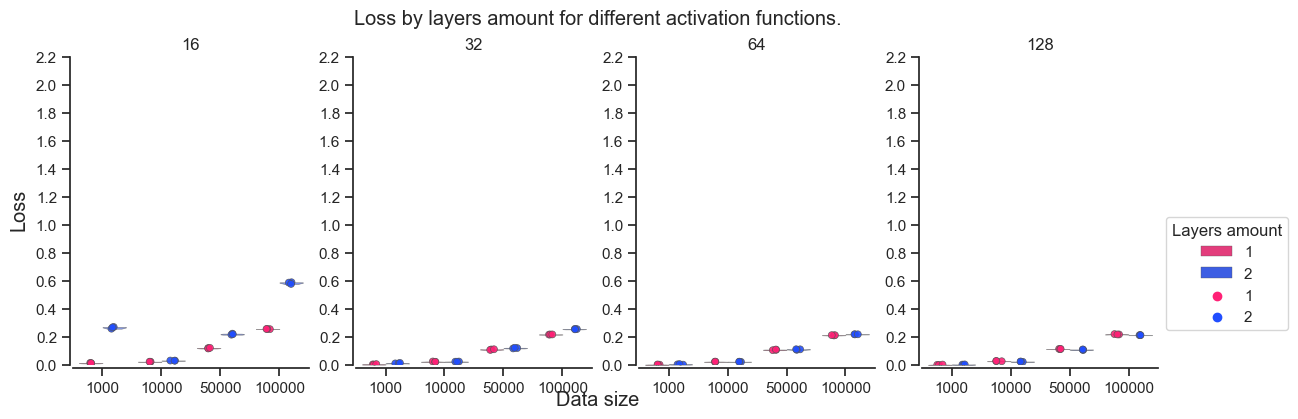

In [15]:
y, ylabel, title, title_separated, val_range = (
    "loss",
    "Loss",
    "Loss by layers amount for all activation functions.",
    "Loss by layers amount for different activation functions.",
    np.arange(0, 2.3, 0.2),
)

print("All together")
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
draw_violins(
    data_viol,
    x="n_rows",
    y=y,
    xlabel="Layers amount",
    ylabel=ylabel,
    title=title,
    hue="num_layers",
    yticks=val_range
)
plt.show()

# ==================================================
print("Separated")

sns.set(rc={"figure.figsize": (14, 4)})
sns.set_theme(style="whitegrid")
# get legend
ax = draw_violins(
    data_viol,
    x="n_rows",
    y=y,
    xlabel="Layers amount",
    ylabel=ylabel,
    title=title_separated,
    hue="num_layers",
    return_ax=True,
    yticks=val_range
)
handles, labels = ax.get_legend_handles_labels()
plt.clf()
# draw
fig, axs = plt.subplots(nrows=1, ncols=4)
for i, act_f in enumerate(data_viol.d_model.unique()):
    row = i // 4
    col = i % 4
    cur_data = data_viol[data_viol.d_model == act_f]
    ax = draw_violins(
        cur_data,
        x="n_rows",
        y=y,
        xlabel="Layers amount",
        ylabel=ylabel,
        title=f"`{act_f}`.",
        hue="num_layers",
        return_ax=True,
        ax=axs[col],
        yticks=val_range
    )
#     plt.setp(ax.collections, alpha=0.58)
    ax.legend_.remove()
    ax.set(ylabel="", xlabel="", title=act_f)
    ax.set(ylim=(min(val_range), max(val_range)))
    ax
fig.supylabel(ylabel, y=0.5, x=0.08)
fig.supxlabel("Data size", y=0, x=0.5)
fig.suptitle(title_separated, y=1, x=0.5)
fig.legend(
    handles, 
    labels, 
    loc="upper left", 
    bbox_to_anchor=(0.9, 0.5), 
    title="Layers amount"
)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2
)
plt.show()